G1 size: 3150, G2 size: 3150, G3 size: 3150, G4 size: 3150
[ML] Best AUC on G2 = 0.9286, best params = (200, 5, 5)
[INFO] transitions_h shape: (21, 5, 5)
[INFO] transitions_s shape: (21, 5, 5)
[INFO] Resource capacity = 346
[ADP] Training Q-Network with time-dependent Markov transitions on G3...


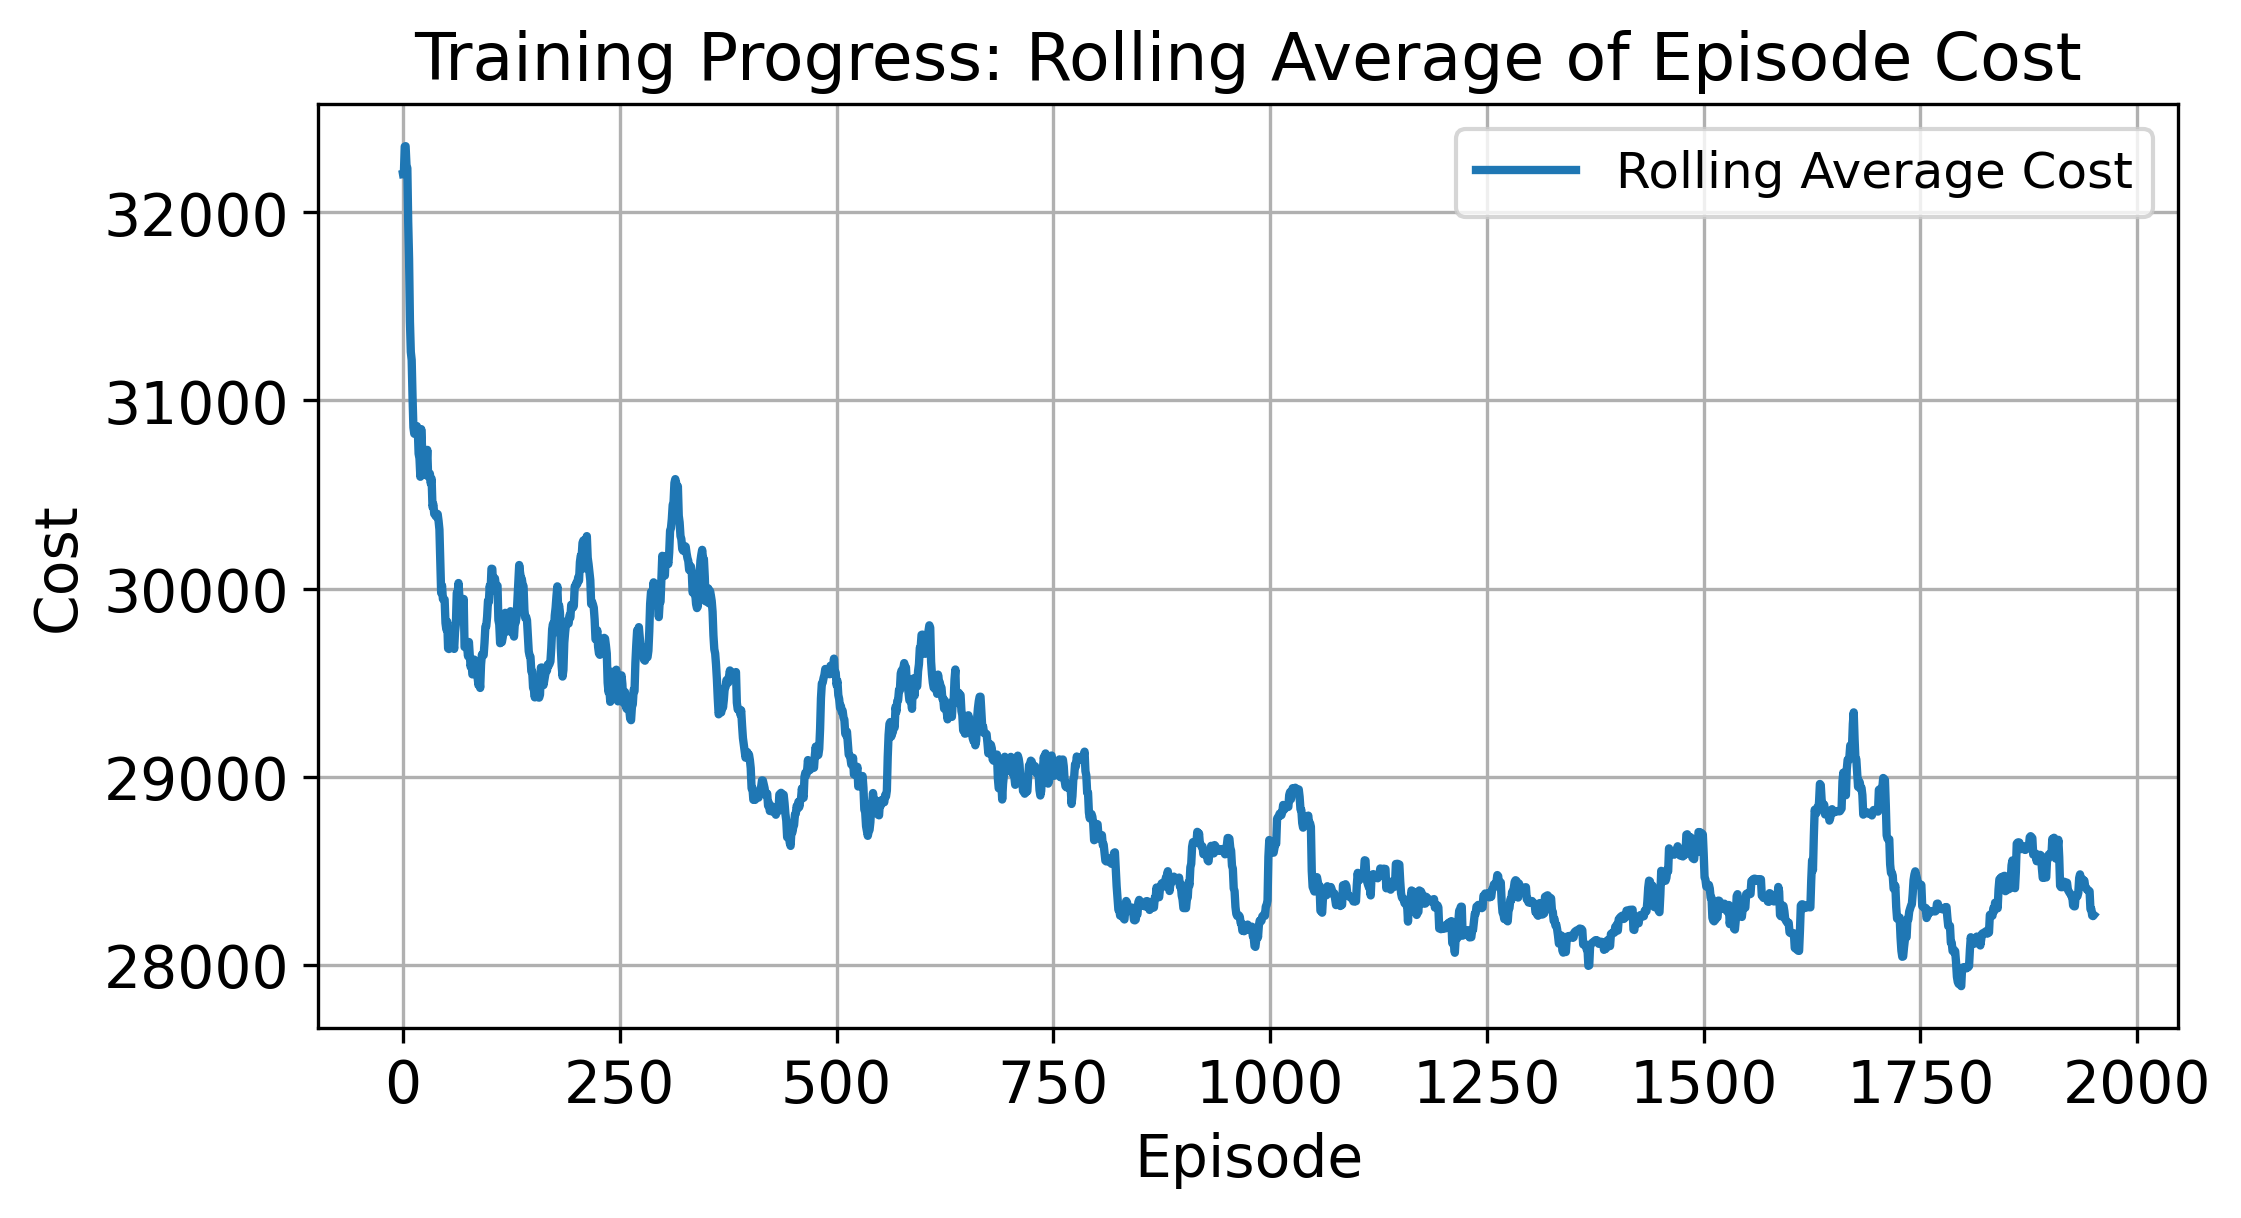

[ADP] Done training Q-network.
===== EVALUATION on G4 (time-dependent Markov, split like Alg0) =====
Total Cost: 26400.14
Avg. Treatment Time: 9.12
Recall: 0.5130
Precision: 0.9963
[ML] RandomForest AUC on G4: 0.9209


In [13]:

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

###############################################################################
# Optional: Adjust some global styles for publication-like figures
###############################################################################
plt.rcParams.update({
    'font.size': 14,            # Increase overall font size
    'axes.labelsize': 14,       # Axis label size
    'axes.titlesize': 16,       # Title size
    'legend.fontsize': 12,      # Legend size
    'figure.dpi': 300,          # Higher DPI for publication-quality
    'savefig.dpi': 300,
    'figure.figsize': (8, 4),   # Default figure size
    'axes.grid': True           # Add grid
})

###############################################################################
# 0. Utility: split data into four groups by patient_id
###############################################################################
def split_into_four_groups(df, seed=0):
    """
    Shuffle patient IDs and split ~evenly into four groups: G1, G2, G3, G4.
    """
    rng = np.random.RandomState(seed)
    unique_pids = df['patient_id'].unique()
    rng.shuffle(unique_pids)
    
    n = len(unique_pids)
    i1 = int(0.25 * n)
    i2 = int(0.50 * n)
    i3 = int(0.75 * n)
    
    G1_pids = unique_pids[: i1]
    G2_pids = unique_pids[i1 : i2]
    G3_pids = unique_pids[i2 : i3]
    G4_pids = unique_pids[i3 : ]
    
    G1 = df[df['patient_id'].isin(G1_pids)].copy()
    G2 = df[df['patient_id'].isin(G2_pids)].copy()
    G3 = df[df['patient_id'].isin(G3_pids)].copy()
    G4 = df[df['patient_id'].isin(G4_pids)].copy()
    
    return G1, G2, G3, G4

###############################################################################
# 1. Data Import & 4-way Split
###############################################################################
df = pd.read_csv("synthetic_patients_with_features.csv")

# For consistency with the first code, let's set T_max=21 and filter:
T_MAX = 21
df = df[df['time'] < T_MAX].copy()

# Now we do a 4-way split by patient_id:
G1, G2, G3, G4 = split_into_four_groups(df, seed=123)
print(f"G1 size: {len(G1)}, G2 size: {len(G2)}, G3 size: {len(G3)}, G4 size: {len(G4)}")

###############################################################################
# 2. Train Random Forest on G1 => select best params on G2 => retrain on G1+G2
###############################################################################
def compute_features(subdf):
    """Use [EIT, NIRS, EIS, time] as features."""
    return subdf[['EIT', 'NIRS', 'EIS', 'time']].values

def prepare_data_for_ml(df_input):
    X_ = compute_features(df_input)
    y_ = df_input['label'].values
    return X_, y_

X1, y1 = prepare_data_for_ml(G1)
X2, y2 = prepare_data_for_ml(G2)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5]
}

best_auc = -np.inf
best_params = None

for n_est in param_grid['n_estimators']:
    for md in param_grid['max_depth']:
        for msl in param_grid['min_samples_leaf']:
            rf_model = RandomForestClassifier(
                n_estimators=n_est,
                max_depth=md,
                min_samples_leaf=msl,
                random_state=0
            )
            rf_model.fit(X1, y1)
            preds_proba = rf_model.predict_proba(X2)[:, 1]
            auc_val = roc_auc_score(y2, preds_proba)
            if auc_val > best_auc:
                best_auc = auc_val
                best_params = (n_est, md, msl)

print(f"[ML] Best AUC on G2 = {best_auc:.4f}, best params = {best_params}")

# Retrain on G1+G2 with best params
X12 = np.vstack([X1, X2])
y12 = np.hstack([y1, y2])
final_rf_model = RandomForestClassifier(
    n_estimators=best_params[0],
    max_depth=best_params[1],
    min_samples_leaf=best_params[2],
    random_state=0
)
final_rf_model.fit(X12, y12)

###############################################################################
# 3. Generate risk scores & map to risk buckets
###############################################################################
def get_risk_scores(df_input, model):
    """Apply trained RF to get risk_score in [0,1]."""
    X_, _ = prepare_data_for_ml(df_input)
    risk_scores = model.predict_proba(X_)[:, 1]
    df_out = df_input.copy()
    df_out['risk_score'] = risk_scores
    return df_out

def bucket_risk(score):
    """
    5 equally sized buckets:
      [0, 0.2) -> 0
      [0.2, 0.4) -> 1
      [0.4, 0.6) -> 2
      [0.6, 0.8) -> 3
      [0.8, 1.0] -> 4
    """
    if score < 0.2:
        return 0
    elif score < 0.4:
        return 1
    elif score < 0.6:
        return 2
    elif score < 0.8:
        return 3
    else:
        return 4

G3_scored = get_risk_scores(G3, final_rf_model)
G3_scored['bucket'] = G3_scored['risk_score'].apply(bucket_risk)

###############################################################################
# 3A. Build time-dependent Markov transitions from G3
###############################################################################
def build_time_dependent_trans_matrices(df_input, T_max=21):
    """
    Build two sets of transition matrices (transitions_h, transitions_s),
    each shape (T_max, 5, 5), from consecutive time steps in the data:
      transitions_h[t, i, j]: prob( healthy in bucket i -> j at time t -> t+1 )
      transitions_s[t, i, j]: prob( sick in bucket i -> j at time t -> t+1 )
    """
    counts_h = np.zeros((T_max, 5, 5), dtype=float)
    counts_s = np.zeros((T_max, 5, 5), dtype=float)

    df_sorted = df_input.sort_values(by=['patient_id', 'time'])
    for pid, group in df_sorted.groupby('patient_id'):
        g_sorted = group.sort_values(by='time').reset_index(drop=True)
        for i in range(len(g_sorted) - 1):
            row_curr = g_sorted.iloc[i]
            row_next = g_sorted.iloc[i + 1]

            t_curr = int(row_curr['time'])
            b_old = int(row_curr['bucket'])
            b_new = int(row_next['bucket'])
            label_val = int(row_curr['label'])  # 0 or 1

            # only collect transitions if next row is exactly time + 1
            if (row_next['time'] == (t_curr + 1)) and (t_curr < T_max - 1):
                if label_val == 0:
                    counts_h[t_curr, b_old, b_new] += 1.0
                else:
                    counts_s[t_curr, b_old, b_new] += 1.0

    transitions_h = np.zeros((T_max, 5, 5), dtype=float)
    transitions_s = np.zeros((T_max, 5, 5), dtype=float)

    for t in range(T_max):
        for i in range(5):
            row_sum_h = counts_h[t, i, :].sum()
            row_sum_s = counts_s[t, i, :].sum()
            if row_sum_h > 1e-9:
                transitions_h[t, i, :] = counts_h[t, i, :] / row_sum_h
            else:
                transitions_h[t, i, i] = 1.0  # self-loop if no data

            if row_sum_s > 1e-9:
                transitions_s[t, i, :] = counts_s[t, i, :] / row_sum_s
            else:
                transitions_s[t, i, i] = 1.0

    return transitions_h, transitions_s

transitions_h, transitions_s = build_time_dependent_trans_matrices(G3_scored, T_max=T_MAX)
print("[INFO] transitions_h shape:", transitions_h.shape)
print("[INFO] transitions_s shape:", transitions_s.shape)

###############################################################################
# 4. ADP environment with time-dependent transitions
###############################################################################
# Cost parameters
FP = 10   # cost for false positives
FN = 50   # cost for false negatives
D  = 1    # cost for daily delay for each sick patient waiting
gamma = 0.99

# Resource capacity = half of sick in G3 (like in the original example)
num_sick_g3 = G3_scored['label'].sum()
N_C = max(0, int(0.5 * num_sick_g3))
print(f"[INFO] Resource capacity = {N_C}")

class AggregatedMarkovEnvTimeDependent:
    """
    Tracks #healthy and #sick in each of 5 buckets (bH[i], bS[i]) plus time t.
    Each step, we choose how many patients to treat (up to capacity).
    The environment treats from highest-risk bucket down to lowest-risk.
    """

    def __init__(self, df_patients, capacity, max_time=21,
                 transitions_h=None, transitions_s=None):
        self.capacity = capacity
        self.max_time = max_time
        self.transitions_h = transitions_h
        self.transitions_s = transitions_s

        # bH[i], bS[i] = # of healthy/sick in bucket i
        bH = np.zeros(5, dtype=float)
        bS = np.zeros(5, dtype=float)
        for i in range(5):
            cond_h = ((df_patients['bucket'] == i) & (df_patients['label'] == 0))
            cond_s = ((df_patients['bucket'] == i) & (df_patients['label'] == 1))
            bH[i] = cond_h.sum()
            bS[i] = cond_s.sum()

        self.bH = bH
        self.bS = bS
        self.treated_so_far = 0.0
        self.cumulative_treatment_time = 0.0
        self.t = 0
        self.done = False

    def reset(self):
        self.treated_so_far = 0.0
        self.cumulative_treatment_time = 0.0
        self.t = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        # state = [bH(5), bS(5), capacity_remaining, t]
        cap_rem = max(0, self.capacity - self.treated_so_far)
        return np.concatenate([self.bH, self.bS, [cap_rem, self.t]])

    def step(self, action):
        global FP, FN, D
        if self.done:
            return self._get_state(), 0.0, True

        # capacity left
        cap_rem = self.capacity - self.treated_so_far
        if cap_rem < 0:
            cap_rem = 0
        act_left = min(action, cap_rem)

        # Treat from highest bucket to lowest
        treated_healthy = 0.0
        treated_sick = 0.0
        actually_treated = 0.0

        for bucket_i in reversed(range(5)):
            if act_left <= 1e-9:
                break
            total_in_bucket = self.bH[bucket_i] + self.bS[bucket_i]
            if total_in_bucket <= 1e-9:
                continue

            can_treat_here = min(act_left, total_in_bucket)
            frac_h = self.bH[bucket_i] / total_in_bucket
            frac_s = self.bS[bucket_i] / total_in_bucket

            treat_h = can_treat_here * frac_h
            treat_s = can_treat_here * frac_s
            self.bH[bucket_i] -= treat_h
            self.bS[bucket_i] -= treat_s

            treated_healthy += treat_h
            treated_sick += treat_s
            actually_treated += can_treat_here
            act_left -= can_treat_here

        self.treated_so_far += actually_treated
        self.cumulative_treatment_time += actually_treated * self.t

        # Immediate cost
        cost_fp = FP * treated_healthy
        cost_delay = D * self.bS.sum()  # daily delay cost for all sick
        cost_fn = 0.0
        done_next = False

        # If final step, all remaining sick => missed => FN cost
        if self.t == (self.max_time - 1):
            done_next = True
            cost_fn = FN * self.bS.sum()

        immediate_cost = cost_fp + cost_delay + cost_fn

        # Advance time
        self.t += 1
        if self.t >= self.max_time:
            done_next = True

        # If not done, apply transitions
        if not done_next:
            t_index = self.t - 1
            if t_index < 0:
                t_index = 0
            if t_index >= self.max_time:
                t_index = self.max_time - 1

            new_bH = np.zeros(5, dtype=float)
            new_bS = np.zeros(5, dtype=float)
            mat_h = self.transitions_h[t_index]
            mat_s = self.transitions_s[t_index]

            for i in range(5):
                if self.bH[i] > 1e-9:
                    for j in range(5):
                        new_bH[j] += self.bH[i] * mat_h[i, j]
                if self.bS[i] > 1e-9:
                    for j in range(5):
                        new_bS[j] += self.bS[i] * mat_s[i, j]

            self.bH = new_bH
            self.bS = new_bS

        self.done = done_next
        return self._get_state(), immediate_cost, done_next

    def get_avg_treatment_time(self):
        if self.treated_so_far <= 1e-9:
            return 0.0
        return self.cumulative_treatment_time / self.treated_so_far

###############################################################################
# 5. Q-Network / ADP
###############################################################################
class QNetwork(nn.Module):
    def __init__(self, state_dim=12, action_dim=21, hidden=64):
        """
        state_dim=12 => bH(5), bS(5), cap_rem, t
        action_dim=21 => we allow up to 20 patients per step + action=0
        Increase if you expect capacity might exceed 20.
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, action_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        qvals = self.fc3(x)  # shape [batch_size, action_dim]
        return qvals

def state_to_tensor(state):
    return torch.tensor([state], dtype=torch.float32)

def choose_action_epsilon_greedy(qnet, state, epsilon, max_action):
    """
    Minimizing cost => pick argmin Q(s,a).
    With probability epsilon, pick random action in [0..max_action].
    """
    if np.random.rand() < epsilon:
        return np.random.randint(0, max_action + 1)
    else:
        with torch.no_grad():
            s_t = state_to_tensor(state)
            qvals = qnet(s_t).numpy().flatten()
            # argmin for cost
            return np.argmin(qvals)

###############################################################################
# 5A. Training function with rolling-average cost plotting & thousand separators
###############################################################################
def train_adp_on_data_time_dependent(
    df_g,
    capacity,
    transitions_h,
    transitions_s,
    max_time=21,
    gamma=0.99,
    episodes=2000,
    learning_rate=1e-3,
    epsilon_start=0.2,
    epsilon_decay=0.999,
    batch_size=64,
    replay_size=20000,
    plot_training=True,
    window_size=50
):
    """
    Train Q-network for aggregated Markov env on df_g, time-dependent transitions.
    We track the total cost per episode, then plot a single, smoothed line
    using a rolling average with 'window_size'. The plot uses thousand separators
    on the x-axis (episode #) and a 2-decimal format on the y-axis (cost).

    Returns
    -------
    qnet : trained QNetwork
    episode_costs : list of cost values per episode
    """
    max_action = min(capacity, 20)
    qnet = QNetwork(state_dim=12, action_dim=(max_action + 1), hidden=64)
    optimizer = optim.Adam(qnet.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    replay_buffer = []
    epsilon = epsilon_start

    episode_costs = []

    def get_target(r, gamma, next_state, done_):
        if done_:
            return r
        else:
            with torch.no_grad():
                qvals_next = qnet(state_to_tensor(next_state)).numpy().flatten()
                # Minimizing cost => best next action => argmin Q
                return r + gamma * np.min(qvals_next)

    for ep in range(episodes):
        # new environment each episode
        env = AggregatedMarkovEnvTimeDependent(
            df_patients=df_g,
            capacity=capacity,
            max_time=max_time,
            transitions_h=transitions_h,
            transitions_s=transitions_s
        )
        s = env.reset()
        done = False
        ep_cost = 0.0

        while not done:
            a = choose_action_epsilon_greedy(qnet, s, epsilon, max_action)
            s_next, cost, done = env.step(a)
            ep_cost += cost

            replay_buffer.append((s, a, cost, s_next, done))
            if len(replay_buffer) > replay_size:
                replay_buffer.pop(0)

            s = s_next

            # Update Q-network if replay buffer has enough samples
            if len(replay_buffer) >= batch_size:
                batch_indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
                states_b, actions_b, targets_b = [], [], []
                for idx in batch_indices:
                    st, ac, c_, sn, dn = replay_buffer[idx]
                    y_ = get_target(c_, gamma, sn, dn)
                    states_b.append(st)
                    actions_b.append(ac)
                    targets_b.append(y_)

                states_t = torch.tensor(states_b, dtype=torch.float32)
                actions_t = torch.tensor(actions_b, dtype=torch.long)
                targets_t = torch.tensor(targets_b, dtype=torch.float32)

                qvals_all = qnet(states_t)
                qvals_chosen = qvals_all.gather(1, actions_t.unsqueeze(1)).squeeze(1)

                loss = loss_fn(qvals_chosen, targets_t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Epsilon decay
        epsilon *= epsilon_decay
        epsilon = max(epsilon, 0.01)

        # Track total cost this episode
        episode_costs.append(ep_cost)

    # Plot rolling average if desired
    if plot_training:
        # Compute rolling average
        if len(episode_costs) < window_size:
            smoothed = episode_costs
        else:
            smoothed = np.convolve(
                episode_costs, 
                np.ones(window_size) / window_size, 
                mode='valid'
            )
        
        fig, ax = plt.subplots()  # use the updated figsize/dpi from rcParams
        ax.plot(smoothed, label='Rolling Average Cost', linewidth=2, color='C0')
        ax.set_title('Training Progress: Rolling Average of Episode Cost')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Cost')
        ax.legend()
        plt.savefig('training_progress.png', dpi=300, bbox_inches='tight')
        plt.show()

    return qnet, episode_costs

###############################################################################
# 5B. Run Q-learning on G3
###############################################################################
print("[ADP] Training Q-Network with time-dependent Markov transitions on G3...")
qnet_final, training_costs = train_adp_on_data_time_dependent(
    df_g=G3_scored,
    capacity=N_C,
    transitions_h=transitions_h,
    transitions_s=transitions_s,
    max_time=T_MAX,
    gamma=gamma,
    episodes=2000,
    learning_rate=1e-3,
    epsilon_start=0.2,
    epsilon_decay=0.999,
    batch_size=64,
    plot_training=True,
    window_size=50
)
print("[ADP] Done training Q-network.")

###############################################################################
# 6. Evaluate final policy on G4
###############################################################################
G4_scored = get_risk_scores(G4, final_rf_model)
G4_scored['bucket'] = G4_scored['risk_score'].apply(bucket_risk)

def evaluate_policy_time_dependent(
    df_input,
    qnet,
    capacity,
    transitions_h,
    transitions_s,
    max_time=21
):
    """
    Evaluate the learned policy on df_input with time-dependent transitions.
    Returns: (total_cost, avg_treatment_time, recall, precision).
    """
    env_eval = AggregatedMarkovEnvTimeDependent(
        df_patients=df_input,
        capacity=capacity,
        max_time=max_time,
        transitions_h=transitions_h,
        transitions_s=transitions_s
    )
    s = env_eval.reset()
    done = False
    total_cost = 0.0

    max_action = min(capacity, 20)

    while not done:
        with torch.no_grad():
            s_t = state_to_tensor(s)
            qvals = qnet(s_t).numpy().flatten()
            # Minimizing cost => pick argmin
            action = np.argmin(qvals)
            if action > max_action:
                action = max_action

        s_next, cost, done = env_eval.step(action)
        total_cost += cost
        s = s_next

    # Summaries for recall, precision
    total_healthy_init = 0.0
    total_sick_init = 0.0
    for i in range(5):
        cond_h = ((df_input['bucket'] == i) & (df_input['label'] == 0))
        cond_s = ((df_input['bucket'] == i) & (df_input['label'] == 1))
        total_healthy_init += cond_h.sum()
        total_sick_init += cond_s.sum()

    final_healthy_remain = env_eval.bH.sum()
    final_sick_remain = env_eval.bS.sum()

    treated_healthy = total_healthy_init - final_healthy_remain
    treated_sick = total_sick_init - final_sick_remain

    if (treated_sick + treated_healthy) > 1e-9:
        precision = treated_sick / (treated_sick + treated_healthy)
    else:
        precision = 0.0

    if (treated_sick + final_sick_remain) > 1e-9:
        recall = treated_sick / (treated_sick + final_sick_remain)
    else:
        recall = 0.0

    avg_treat_time = env_eval.get_avg_treatment_time()

    return total_cost, avg_treat_time, recall, precision

final_cost_G4, avg_tt_G4, recall_G4, precision_G4 = evaluate_policy_time_dependent(
    df_input=G4_scored,
    qnet=qnet_final,
    capacity=N_C,
    transitions_h=transitions_h,
    transitions_s=transitions_s,
    max_time=T_MAX
)

print("===== EVALUATION on G4 (time-dependent Markov, split like Alg0) =====")
print(f"Total Cost: {final_cost_G4:.2f}")
print(f"Avg. Treatment Time: {avg_tt_G4:.2f}")
print(f"Recall: {recall_G4:.4f}")
print(f"Precision: {precision_G4:.4f}")

# Also check final RandomForest AUC on G4 for reference
X4, y4 = prepare_data_for_ml(G4)
proba4 = final_rf_model.predict_proba(X4)[:, 1]
auc_g4 = roc_auc_score(y4, proba4)
print(f"[ML] RandomForest AUC on G4: {auc_g4:.4f}")